<a href="https://colab.research.google.com/github/varunsboy17/Credit-Card-Fraud/blob/master/CreditCardFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import re

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from tqdm import tqdm

pd.options.display.float_format = '{:.3f}'.format

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
%%time
path_train_trans = "/content/drive/My Drive/Credit Card Fraud Dataset/train_transaction.csv"
path_train_id = "/content/drive/My Drive/Credit Card Fraud Dataset/train_identity.csv"
path_test_trans = "/content/drive/My Drive/Credit Card Fraud Dataset/test_transaction.csv"
path_test_id = "/content/drive/My Drive/Credit Card Fraud Dataset/test_identity.csv"

train_transaction = pd.read_csv(path_train_trans)
train_identity = pd.read_csv(path_train_id)
test_transaction = pd.read_csv(path_test_trans)
test_identity = pd.read_csv(path_test_id)

#train_transaction = pd.read_csv(b'D:\\Personal\\SR\\Credit card Fraud\\ieee-fraud-detection\\train_transaction.csv')
#train_identity = pd.read_csv("D:\\Personal\\SR\\Credit card Fraud\\ieee-fraud-detection\\train_identity.csv")
#test_transaction = pd.read_csv("D:\\Personal\\SR\\Credit card Fraud\\ieee-fraud-detection\\test_transaction.csv")
#test_identity = pd.read_csv("D:\\Personal\\SR\\Credit card Fraud\\ieee-fraud-detection\\test_identity.csv")

CPU times: user 52.8 s, sys: 7.44 s, total: 1min
Wall time: 1min 3s


In [0]:
def reduce_mem_usage(df):
  start_mem = df.memory_usage().sum() /1024 **2
  print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
  for col in df.columns:
    col_type = df[col].dtype
    
    if col_type != object:
      cmin = df[col].min()
      cmax = df[col].max()
      if str(col_type)[:3] == 'int':
        if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
        if cmin > np.finfo(np.float16).min and cmax > np.finfo(np.float16).max:
          df[col] = df[col].astype(np.float16)
        elif cmin > np.finfo(np.float32).min and cmax > np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)
    else:
      df[col] = df[col].astype('category')
  end_mem = df.memory_usage().sum() / 1024 ** 2
  print("Memory usage after optimization is {:.2f} MB".format(end_mem))
  print("Decreased by {:.1f} %".format(100 * (start_mem - end_mem) / start_mem))
    

In [65]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500,W,13926,nan,150.000,discover,142.000,credit,315.000,87.000,19.000,nan,NaN,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.000,0.000,1.000,1.000,14.000,nan,13.000,nan,nan,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,117.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,117.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,credit,325.000,87.000,nan,nan,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,debit,330.000,87.000,287.000,nan,outlook.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,debit,476.000,87.000,nan,nan,yahoo.com,NaN,2.000,5.000,0.000,0.000,0.000,4.000,0.000,0.000,1.000,0.000,1.000,0.000,25.000,1.000,112.000,112.000,0.000,94.000,0.000,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,50.000,1758.000,925.000,0.000,354.000,0.000,135.000,0.000,0.000,0.000,50.000,1404.000,790.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,credit,420.000,87.000,nan,nan,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,...,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [0]:
#train_trns = reduce_mem_usage(train_transaction)
#train_identity = reduce_mem_usage(train_identity)
#test_transaction = reduce_mem_usage(test_transaction)
#test_identity = reduce_mem_usage(test_identity)

In [67]:
print(train_transaction.shape, test_transaction.shape)
print(train_identity.shape, test_identity.shape)

(590540, 394) (506691, 393)
(144233, 41) (141907, 41)


In [68]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.000,70787.000,nan,nan,nan,nan,nan,nan,nan,nan,100.000,NotFound,nan,-480.000,New,NotFound,166.000,nan,542.000,144.000,nan,nan,NaN,nan,nan,nan,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.000,98945.000,nan,nan,0.000,-5.000,nan,nan,nan,nan,100.000,NotFound,49.000,-300.000,New,NotFound,166.000,nan,621.000,500.000,nan,nan,NaN,nan,nan,nan,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.000,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.000,191631.000,0.000,0.000,0.000,0.000,nan,nan,0.000,0.000,100.000,NotFound,52.000,nan,Found,Found,121.000,nan,410.000,142.000,nan,nan,NaN,nan,nan,nan,NaN,Found,Found,NaN,chrome 62.0,nan,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.000,221832.000,nan,nan,0.000,-6.000,nan,nan,nan,nan,100.000,NotFound,52.000,nan,New,NotFound,225.000,nan,176.000,507.000,nan,nan,NaN,nan,nan,nan,NaN,New,NotFound,NaN,chrome 62.0,nan,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.000,7460.000,0.000,0.000,1.000,0.000,nan,nan,0.000,0.000,100.000,NotFound,nan,-300.000,Found,Found,166.000,15.000,529.000,575.000,nan,nan,NaN,nan,nan,nan,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.000,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [69]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500,W,13926,nan,150.000,discover,142.000,credit,315.000,87.000,19.000,nan,NaN,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.000,0.000,1.000,1.000,14.000,nan,13.000,nan,nan,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,117.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,117.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,credit,325.000,87.000,nan,nan,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,debit,330.000,87.000,287.000,nan,outlook.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,debit,476.000,87.000,nan,nan,yahoo.com,NaN,2.000,5.000,0.000,0.000,0.000,4.000,0.000,0.000,1.000,0.000,1.000,0.000,25.000,1.000,112.000,112.000,0.000,94.000,0.000,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,50.000,1758.000,925.000,0.000,354.000,0.000,135.000,0.000,0.000,0.000,50.000,1404.000,790.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,credit,420.000,87.000,nan,nan,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,...,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [70]:
[c for c in train_transaction.columns if c not in test_transaction.columns]

['isFraud']

,0,1
isFraud,0.965,0.035


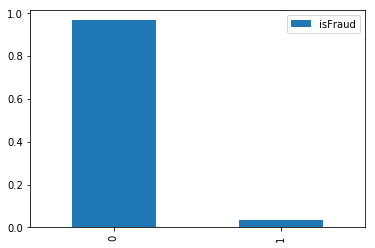

In [71]:
fc = train_transaction["isFraud"].value_counts(normalize=True).to_frame()
fc.plot.bar()
fc.T

In [0]:
#fig, ax = plt.subplots(2,1, figsize=(16,8))
#train_transaction['_seq_day'] = train_transaction['TransactionDT']
#train_transaction['_seq_week'] = train_transaction['_seq_day']
#train_transaction.groupby('_seq_day')['isFraud'].mean().to_frame().plot.line(ax=ax[0])
#train_transaction.groupby('_seq_week')['isFraud'].mean().to_frame().plot.line(ax=ax[1])
#plt.show()

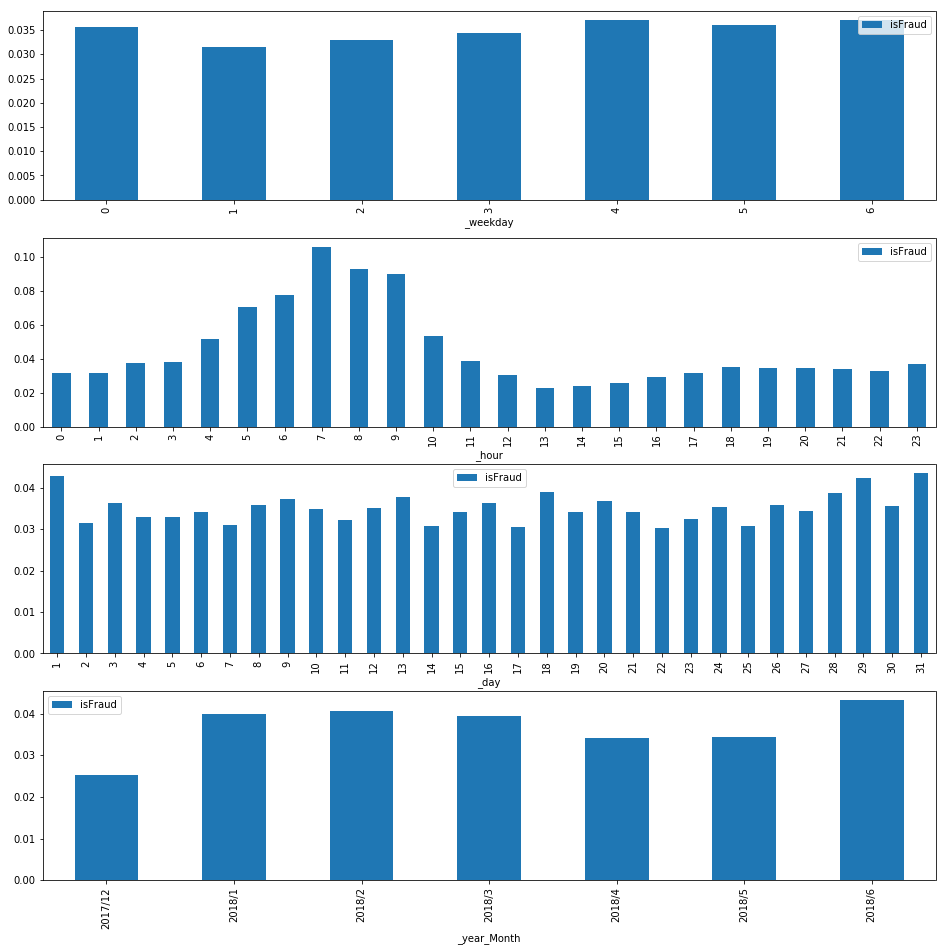

In [73]:
# Fraud transaction rate by weekday, hour, month-day, and year-month
import datetime
START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train_transaction['Date'] = train_transaction['TransactionDT'].apply(lambda x:start_date + datetime.timedelta(seconds=x))
train_transaction['_year_Month'] = train_transaction['Date'].dt.year.astype(str) + '/' + train_transaction['Date'].dt.month.astype(str)
train_transaction['_weekday'] = train_transaction['Date'].dt.dayofweek
train_transaction['_hour'] = train_transaction['Date'].dt.hour
train_transaction['_day'] = train_transaction['Date'].dt.day

fig, ax = plt.subplots(4, 1, figsize=(16,16))
train_transaction.groupby('_weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train_transaction.groupby('_hour')['isFraud'].mean().to_frame().plot.bar(ax=ax[1])
train_transaction.groupby('_day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
train_transaction.groupby('_year_Month')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

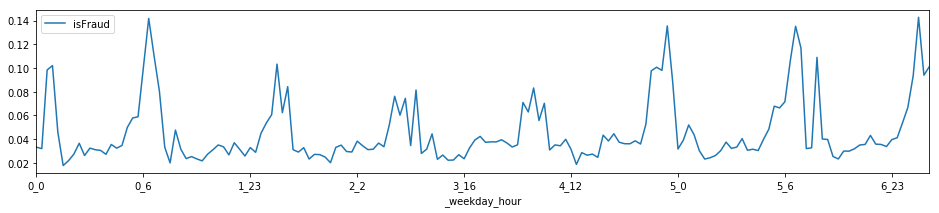

In [74]:
# Fraud transaction rate by weekday hour
train_transaction['_weekday_hour'] = train_transaction['_weekday'].astype(str) + '_' + train_transaction['_hour'].astype(str)
train_transaction.groupby('_weekday_hour')['isFraud'].mean().to_frame().plot.line(figsize=(16,3))

In [75]:
df = train_transaction.groupby('_weekday')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)

,isFraud
_weekday,
4,0.037
6,0.037
5,0.036
0,0.036
3,0.035
2,0.033
1,0.031


In [76]:
df = train_transaction.groupby('_hour')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False).head(10)

,isFraud
_hour,
7,0.106
8,0.093
9,0.090
6,0.078
5,0.070
10,0.053
4,0.052
11,0.039
3,0.038


In [77]:
df = train_transaction.groupby('_weekday_hour')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False).head(10)

,isFraud
_weekday_hour,
6_7,0.143
0_7,0.142
4_8,0.136
5_8,0.135
5_9,0.117
0_8,0.110
6_10,0.109
5_7,0.106
1_7,0.103


In [78]:
train_transaction['_amount_qcut'] = pd.qcut(train_transaction['TransactionAmt'], 10)
df = train_transaction.groupby('_amount_qcut')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)

,isFraud
_amount_qcut,
"(0.25, 25.95]",0.056
"(275.293, 31937.391]",0.051
"(117.0, 159.95]",0.043
"(159.95, 275.293]",0.038
"(68.769, 100.0]",0.036
"(35.95, 49.0]",0.032
"(25.95, 35.95]",0.032
"(57.95, 68.769]",0.029
"(100.0, 117.0]",0.020


In [79]:
fraud_id = train_transaction[train_transaction['isFraud'] == 1]['TransactionID']
fraud_id_in_identity = [i for i in fraud_id if i in train_identity['TransactionID'].values]
print(f'Fraud id in transaction:{len(fraud_id)} and in identity:{len(fraud_id_in_identity)}')

Fraud id in transaction:20663 and in identity:11318


In [80]:
train_id_trns = pd.merge(train_identity, train_transaction[['isFraud', 'TransactionID']])
train_id_trns_f0 = train_id_trns[train_id_trns['isFraud'] == 0]
train_id_trns_f1 = train_id_trns[train_id_trns['isFraud'] == 1]
del train_id_trns

print(train_id_trns_f0.shape)
print(train_id_trns_f1.shape)

def plotHistByFraud(col, bins=20, figsize=(8,3)):
  with np.errstate(invalid='ignore'):
    plt.figure(figsize=figsize)
    plt.hist([train_id_trns_f0[col], train_id_trns_f1[col]], bins=bins, density=True, color=['royalblue', 'orange'])
    
def plotCategoryRateBar(col, topN=np.nan, figsize=(8,3)):
  a, b = train_id_trans_f0, train_id_trns_f1
  if topN==topN:
    vals = b[col].value_counts(normalize=True).to_frame().iloc[:topN,0]
    subA = a.loc[a[col].isin(vals.index.values), col]
    df = pd.DataFrame({'normal': subA.value_counts(normalize=True), 'fraud':vals})
  else:
    df = pd.DataFrame({'normal':a[col].value_counts(normalize=True), 'fraud':b[col].value_counts(normalize=True)})
  df.sort_values('fraud', ascending=False).plot.bar(figsize=figsize)

(132915, 42)
(11318, 42)


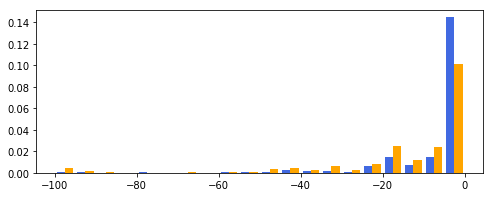

In [81]:
plotHistByFraud('id_01')

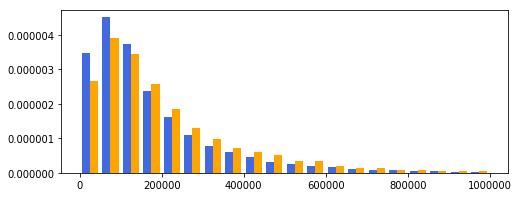

In [82]:
plotHistByFraud('id_02')

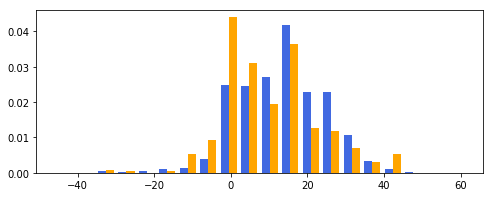

In [83]:
plotHistByFraud('id_07')

In [0]:
train_transaction = pd.read_csv(path_train_trans)
train_identity = pd.read_csv(path_train_id)
test_transaction = pd.read_csv(path_test_trans)
test_identity = pd.read_csv(path_test_id)

id_cols = list(train_identity.columns.values)
trn_cols = list(train_transaction.drop('isFraud', axis=1).columns.values)


X_train = pd.merge(train_transaction[trn_cols + ['isFraud']], train_identity[id_cols], how='left')
X_test = pd.merge(test_transaction[trn_cols], test_identity[id_cols], how='left')

X_train_id = X_train.pop('TransactionID')
X_test_id = X_test.pop('TransactionID')


del train_transaction, train_identity, test_transaction, test_identity

all_data = X_train.append(X_test, sort=False).reset_index(drop=True)

In [0]:
all_data['_nulls'] = all_data.isnull().sum(axis=1)

In [0]:
vcols = [f'V{i}' for i in range(1,340)]
sc = preprocessing.MinMaxScaler()
pca = PCA(n_components=2)
vcol_pca = pca.fit_transform(sc.fit_transform(all_data[vcols].fillna(-1)))

all_data['_vcol_pca0'] = vcol_pca[:,0]
all_data['_vcol_pca1'] = vcol_pca[:,1]
all_data['_vcol_nulls'] = all_data[vcols].isnull().sum(axis=1)

In [0]:
all_data.drop(vcols, axis=1, inplace=True)

In [0]:
all_data['card4'].fillna('unknown', inplace=True)
all_data['card6'].fillna('unknown', inplace=True)

all_data['P_emaildomain'].fillna('unknown', inplace=True)
all_data['R_emaildomain'].fillna('unknown', inplace=True)

In [0]:
START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
all_data['Date'] = all_data['TransactionDT'].apply(lambda x: start_date + datetime.timedelta(seconds=x))
all_data['_weekday'] = all_data['Date'].dt.weekday
all_data['_hour'] = all_data['Date'].dt.hour

all_data['_weekday'] = all_data['_weekday'].astype(str)
all_data['_hour'] = all_data['_hour'].astype(str)
all_data['_weekday__hour'] = all_data['_weekday'] + all_data['_hour']

all_data.drop(['TransactionDT','Date'], axis=1, inplace=True)

In [0]:
all_data['id_31_ua'] = all_data['id_31'].apply(lambda x : x.split()[0] if x == x else 'unknown')

In [0]:
all_data['_P_emaildomain__addr1'] = all_data['P_emaildomain'] + '__' + all_data['addr1'].astype(str)
all_data['_card1__card2'] = all_data['card1'].astype(str) + '__' + all_data['card2'].astype(str)
all_data['_card1__addr1'] = all_data['card1'].astype(str) + '__' + all_data['addr1'].astype(str)
all_data['_card2__addr1'] = all_data['card2'].astype(str) + '__' + all_data['addr1'].astype(str)
all_data['_card12__addr1'] = all_data['_card1__card2'] + '__' + all_data['addr1'].astype(str)
all_data['_card_all__addr1'] = all_data['_card12__addr1'] + '__' + all_data['addr1'].astype(str)

In [92]:
all_data['_amount_decimal'] = ((all_data['TransactionAmt'] - all_data['TransactionAmt'].astype(int)) * 1000).astype(int)
all_data['_amount_decimal_len'] = all_data['TransactionAmt'].apply(lambda x : len(re.sub('0+$','',str(x)).split('.')[1]))
all_data['_amount_fraction'] = all_data['TransactionAmt'].apply(lambda x : float('0.' + re.sub('^[0-9]|\.|0+$','',str(x))))
all_data[['TransactionAmt','_amount_decimal','_amount_decimal_len','_amount_fraction']].head(10)

,TransactionAmt,_amount_decimal,_amount_decimal_len,_amount_fraction
0,68.500,500,1,0.850
1,29.000,0,0,0.900
2,59.000,0,0,0.900
3,50.000,0,0,0.000
4,50.000,0,0,0.000
5,49.000,0,0,0.900
6,159.000,0,0,0.590
7,422.500,500,1,0.225
8,15.000,0,0,0.500
9,117.000,0,0,0.170


In [0]:
cols = ['ProductCD','card1','card2','card5','card6','P_emaildomain','_card_all__addr1']

for f in cols:
  all_data[f'_amount_mean_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('mean')
  all_data[f'_amount_std_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('std')
  all_data[f'_amount_pct_{f}'] = (all_data['TransactionAmt'] - all_data[f'_amount_mean_{f}']) / all_data[f'_amount_std_{f}']
  
# Frequency encoding
for f in cols:
  vc = all_data[f].value_counts(dropna=False)
  all_data[f'_count_{f}'] = all_data[f].map(vc)

In [94]:
print("Features:", all_data.shape)

Features: (1097231, 138)


In [95]:
cat_cols = [f'id_{f}' for i in range(12,39)]
for i in cat_cols:
  if i in all_data.columns:
    all_data[i] = all_data[i].astype(str)
    all_data[i].fillna('unknown', inplace=True)
    
enc_cols = []

for i,t in all_data.loc[:,all_data.columns != 'isFraud'].dtypes.iteritems():
  if t == object:
    enc_cols.append(i)
    all_data[i] = pd.factorize(all_data[i])[0]
    
print(enc_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', '_weekday', '_hour', '_weekday__hour', 'id_31_ua', '_P_emaildomain__addr1', '_card1__card2', '_card1__addr1', '_card2__addr1', '_card12__addr1', '_card_all__addr1']


In [0]:
X_train = all_data[all_data['isFraud'].notnull()]
X_test = all_data[all_data['isFraud'].isnull()].drop('isFraud', axis=1)
Y_train = X_train.pop('isFraud')
del all_data

Prediction

In [0]:
import lightgbm as lgb

In [0]:
params = {'learning_rate':0.01,
         'objective':'binary',
         'metric':'auc',
         'num_threads':-1,
         'num_leaves':256,
         'verbose':1,
         'random_state':42,
         'bagging_fraction':1,
         'feature_fraction':0.85}

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

clf = lgb.LGBMClassifier(**params, n_estimators=3000)
clf.fit(X_train, Y_train)

oof_preds = clf.predict_proba(X_train, num_iteration=clf.best_iteration_)[:,1]
sub_preds = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:,1]

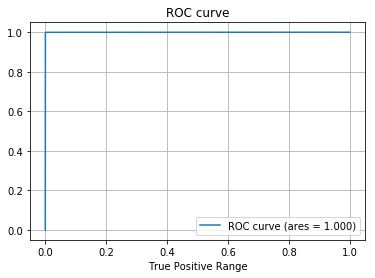

In [99]:
fpr, tpr, thresholds = metrics.roc_curve(Y_train, oof_preds)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (ares = %.3f)' %auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Range')
plt.xlabel('True Positive Range')
plt.grid(True)

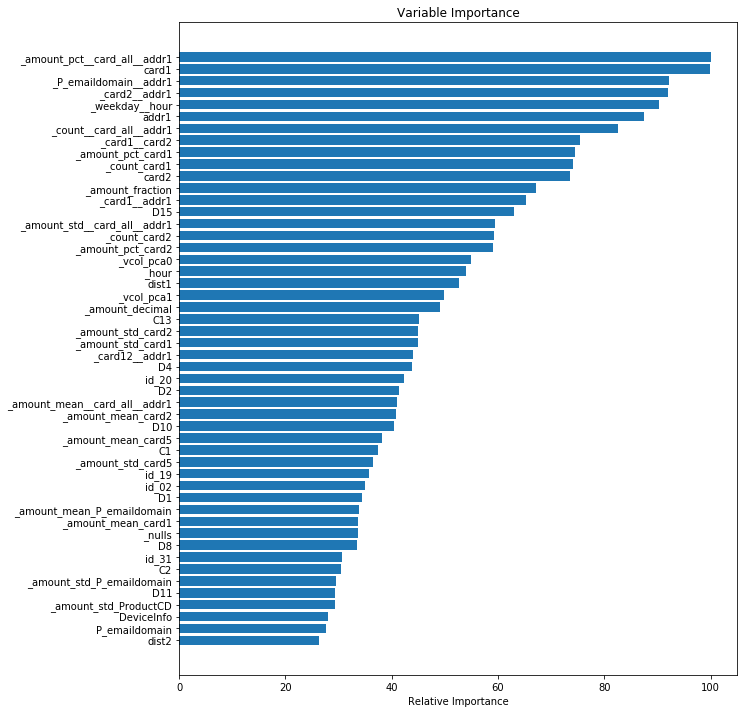

In [100]:
feature_importance = clf.feature_importances_
feature_importance = 100 * (feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 50:]
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.figure(figsize = (10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [101]:
X_train.columns[np.argsort(-feature_importance)].values

array(['_amount_pct__card_all__addr1', 'card1', '_P_emaildomain__addr1',
       '_card2__addr1', '_weekday__hour', 'addr1',
       '_count__card_all__addr1', '_card1__card2', '_amount_pct_card1',
       '_count_card1', 'card2', '_amount_fraction', '_card1__addr1',
       'D15', '_amount_std__card_all__addr1', '_count_card2',
       '_amount_pct_card2', '_vcol_pca0', '_hour', 'dist1', '_vcol_pca1',
       '_amount_decimal', 'C13', '_amount_std_card2', '_amount_std_card1',
       '_card12__addr1', 'D4', 'id_20', 'D2',
       '_amount_mean__card_all__addr1', '_amount_mean_card2', 'D10',
       '_amount_mean_card5', 'C1', '_amount_std_card5', 'id_19', 'id_02',
       'D1', '_amount_mean_P_emaildomain', '_amount_mean_card1', '_nulls',
       'D8', 'id_31', 'C2', '_amount_std_P_emaildomain', 'D11',
       '_amount_std_ProductCD', 'DeviceInfo', 'P_emaildomain', 'dist2',
       '_amount_mean_ProductCD', '_amount_pct_P_emaildomain', 'D3',
       '_amount_pct_card5', 'C6', '_count_P_emaildomain'

In [0]:
submission = pd.DataFrame()
submission['TransactionID'] = X_test_id
submission['isFraud'] = sub_preds
submission.to_csv('submission.csv', index=False)

In [103]:
np.mean(sub_preds)

0.020789868164036312

In [104]:
len(sub_preds[sub_preds > 0.99]), len(sub_preds)

(2205, 506691)